In [2]:
import pygsp as p
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import cv2

In [3]:
paths = ["imgs/im_proc/cameraman.jpg", "imgs/im_proc/pikachu.png", "imgs/im_proc/small_pikachu.png"]

In [4]:
def setup(path):
    
    image = np.flip(cv2.imread(path), axis = -1)/255
    sizex, sizey = np.shape(image)[:2]
    image_flatten = image.reshape(sizex * sizey, 3).T
    
    return image, image_flatten, (sizex, sizey)

def crop(image, x, y, t):
    
    crop_image = image[y : y + t, x : x + t]
    crop_image_flatten = crop_image.reshape(t * t, 3).T
    
    return crop_image, crop_image_flatten

def make_noisy_image(path, mu = 0, sigma = 0.2):
    
    image, image_flatten, sizes = setup(path)
    sizex, sizey = np.shape(image)[:2]
    
    r_noisy = image_flatten[0] + np.random.normal(mu, sigma, size = len(image_flatten[0]))
    b_noisy = image_flatten[1] + np.random.normal(mu, sigma, size = len(image_flatten[2])) ## indices trocados para converter rgb em rbg
    g_noisy = image_flatten[2] + np.random.normal(mu, sigma, size = len(image_flatten[1])) ## indices trocados para converter rgb em rbg
    
    noises = np.array([r_noisy, b_noisy, g_noisy])
    image_noisy = noises.T.reshape(sizex, sizey, 3)
    
    return image_noisy, noises

In [5]:
i, x, y, t = 0, 92, 30, 80
mu, sigma = 0, 0.1

image, image_flatten, (sizex, sizey) = setup(paths[i])
crop_image, crop_image_flatten = crop(image, x, y, t)

image_noisy, noises = make_noisy_image(paths[i], mu, sigma)
crop_image_noisy, crop_image_noisy_flatten = crop(image_noisy, x, y, t)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


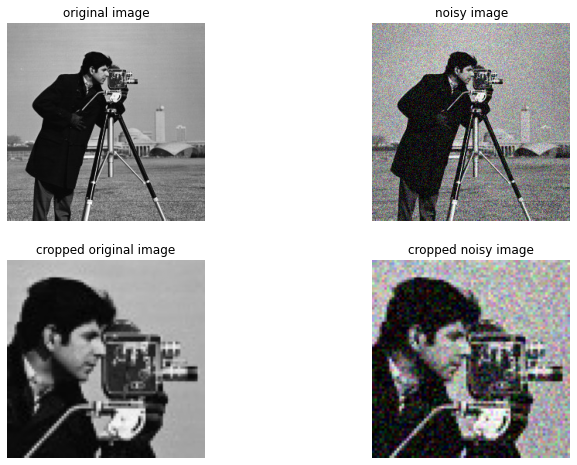

In [6]:
titles = [['original image', 'noisy image'], ['cropped original image', 'cropped noisy image']]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
# fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0][0].imshow(image)
ax[1][0].imshow(crop_image)
ax[1][1].imshow(crop_image_noisy)
ax[0][1].imshow(image_noisy)

for i in [0,1]:
    for j in [0,1]:
        ax[i][j].axis('off')
        ax[i][j].set_title(titles[i][j])
# ax[2].axis('off')
plt.show()

In [7]:
def h(x, tau = 1):
    return 1. / (1. + tau * x)

def denoise_signal(G, tau, image_noisy):

    G.estimate_lmax()
    f = lambda x: h(x, tau)
    g = p.filters.Filter(G, f)
    
    sizex, sizey = np.shape(image_noisy)[:2]
    noises = image_noisy.reshape(sizex * sizey, 3).T
    r_denoised, g_denoised, b_denoised = g.filter(noises[0]), g.filter(noises[1]), g.filter(noises[2])
    image_denoised = np.array([r_denoised, g_denoised, b_denoised]).T.reshape(sizex, sizey, 3)
    
    return image_denoised

def generate_grid(image):
    
    sizex, sizey = np.shape(image)[:2]
    xs = np.linspace(0, 1, sizex)
    ys = np.linspace(0, 1, sizey)
    # full coorindate arrays
    data = np.rot90(np.array(np.meshgrid(ys, xs)).T, k = 1)
    data = data.reshape(sizex * sizey, 2)
    return data

In [8]:
1/sizex * np.sqrt(2) + 1e-4

0.005624271728019903

In [9]:
np.sqrt((1 / sizex) ** 2 + (1 / sizey) ** 2) + 1e-4

0.005624271728019903

In [10]:
data = generate_grid(image)
eps = np.sqrt((1 / sizex) ** 2 + (1 / sizey) ** 2) + 1e-4
eps = 1/sizex * np.sqrt(2) + 1e-4
# eps = 0.02301448

G = p.graphs.Grid2d(sizex, sizey)

L = p.graphs.NNGraph(Xin = data, NNtype = 'radius', epsilon = eps, center = False, rescale = False)

In [11]:
## demora muito se a imagem for grande
# image_noisy_flatten = image_noisy.reshape(sizex * sizey, 3)
# for i in range(sizex * sizey):
#     print(i)
#     for j in range(i, sizex * sizey):
#         if L.W[i,j] != 0:
#             L.W[i,j] = np.exp(-(np.linalg.norm(image_noisy_flatten[i] - image_noisy_flatten[j]))/(2 * 0.1 ** 2))

In [12]:
G.N, L.N, G.Ne, L.Ne

(65536, 65536, 130560, 260610)

In [13]:
tau = 1
G_image_denoised = denoise_signal(G, tau, image_noisy)
G_crop_image_denoised, G_crop_image_denoised_flatten = crop(G_image_denoised, x, y, t)

L_image_denoised = denoise_signal(L, tau, image_noisy)
L_crop_image_denoised, L_crop_image_denoised_flatten = crop(L_image_denoised, x, y, t)

In [14]:
sizex * sizey

65536

In [15]:
np.shape(image_noisy.reshape(sizex * sizey, 3))

(65536, 3)

In [16]:
# titles = [['original image', 'noisy image', 'denoised image'], ['cropped original image', 'cropped noisy image', 'cropped denoised image']]
titles = [['original image', 'noisy image', 'cropped noisy image'], ['original image', 'denoised image (grid)', 'cropped denoised image (grid)'], ['original image', 'cropped denoised image (grid diagonals)', 'cropped denoised image (grid diagonals)']]

# imgs = [[image, image_noisy, image_denoised], [crop_image, crop_image_noisy, crop_image_denoised]]
imgs = [[image, image_noisy, crop_image_noisy],
        [image, G_image_denoised, G_crop_image_denoised],
        [image, L_image_denoised, L_crop_image_denoised], 
        ]
# imgs = [[image, image_noisy, L_image_denoised], [image - image, image - image_noisy, image - image_denoised]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


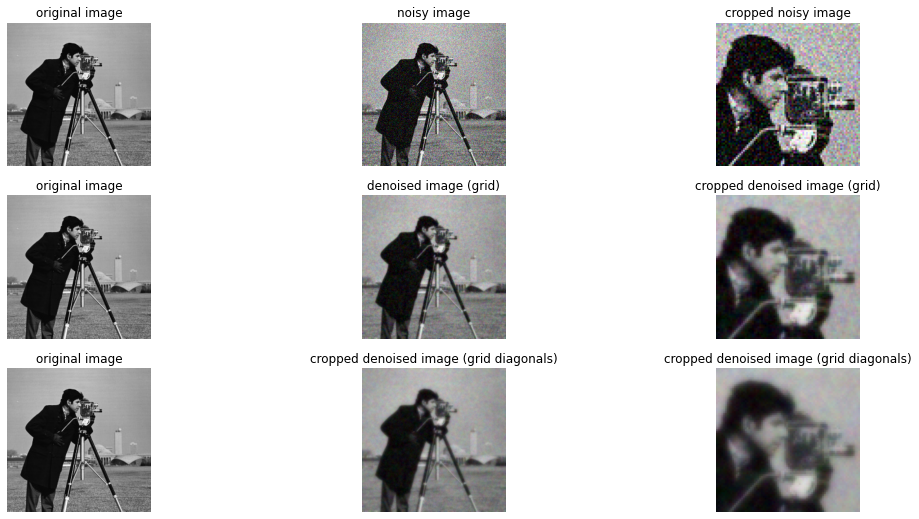

In [17]:
fig, ax = plt.subplots(3, 3, figsize = (18, 9))

for i in [0,1, 2]:
    for j in [0,1, 2]:
        ax[i][j].imshow(imgs[i][j])
        ax[i][j].axis('off')
        ax[i][j].set_title(titles[i][j])
# fig.suptitle('Usual grid graph')
plt.show()

In [13]:
%%time
diagrams = ripser(data, thresh=1)['dgms'] #thresh é maior valor de epsilon que a função considera
## demora MUITO, fazer só com imagens pequenas

CPU times: user 4min 46s, sys: 3.02 s, total: 4min 49s
Wall time: 4min 52s


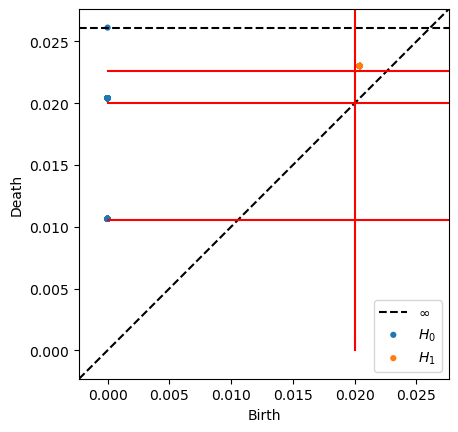

In [25]:
fig, ax = plt.subplots(1,1)
plot_diagrams(diagrams, ax = ax)
ax.plot([1/sizex, 1/sizex], [0,sizey], color = 'red')
ax.plot([0, sizex], [1/sizex,1/sizex], color = 'red')
ax.plot([0, sizex], [1/sizey,1/sizey], color = 'red')
ax.plot([0, sizex], [np.sqrt((1/sizey) ** 2 + (1/sizex) ** 2),np.sqrt((1/sizey) ** 2 + (1/sizex) ** 2)], color = 'red')


In [26]:
# eps = np.sqrt((1 / sizex) ** 2 + (1 / sizey) ** 2)
eps = 0.02301448

In [27]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255
gray_signal = gray_image.reshape(sizex * sizey)
noisy_gray_signal = gray_signal + np.random.normal(mu, sigma, size = sizex * sizey)

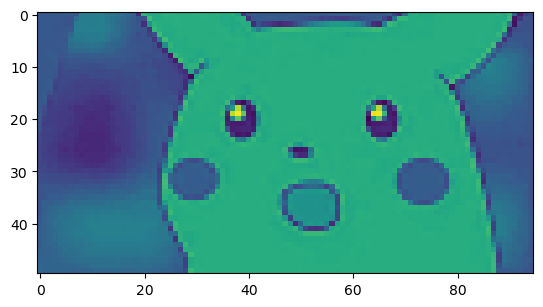

In [29]:
plt.imshow(gray_image)

In [18]:
# for i, eps in enumerate(np.arange(1.1/sizey, 0.2, 0.5/sizey)):
# # for i, eps in enumerate([1/sizey + 1e-3, 1/sizex + 1e-3, np.sqrt((1/sizey) ** 2 + (1/sizex) ** 2) + 1e-7]):
#     print(i, eps)
#     L = p.graphs.NNGraph(Xin = data, NNtype = 'radius', epsilon = eps, center = False, rescale = False)
#     L.estimate_lmax()
#     l = p.filters.Filter(L, h)
#     denoised_gray_signal = l.filter(noisy_gray_signal)
#     plt.ion()
#     fig, ax = plt.subplots(1, 3, figsize=(15,5))
#     ax[0].imshow(gray_signal.reshape(sizex, sizey))
#     ax[1].imshow(noisy_gray_signal.reshape(sizex, sizey))
#     ax[2].imshow(denoised_gray_signal.reshape(sizex, sizey))
#     titles = ['original gray image', 'noisy image', 'filtered image' + '\n' 'graph has ' + str(L.Ne) + ' edges' + '\n' 'max difference between denoised signal and original signal is ' + str(np.linalg.norm(denoised_gray_signal - gray_signal))]
#     for j in [0,1,2]:
#         ax[j].axis('off')
#         ax[j].set_title(titles[j])
#     plt.savefig("imgs/test2/" + str(i) )
#     plt.close(fig)